# RS Lepton Sector Scan — Visualization

Analysis of the parameter scan over $(c_L, c_N, \Lambda_{\text{IR}}, m_{\text{lightest}})$ with filters:
- Perturbativity: $|\bar{Y}| < 4$
- Naturalness: $|\bar{Y}| \in [0.1, 4.0]$
- LFV: $|(\bar{Y}_N \bar{Y}_N^\dagger)_{12}| \leq C \times (M_{KK}/3\,\text{TeV})^2$ with MEG II 2025 bound

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

plt.rcParams.update({
    'figure.dpi': 130,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

## 1. Load scan data

In [2]:
files = sorted(glob.glob('scan_outputs/scan_shard_*_of_016.csv'))
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
print(f'Loaded {len(df):,} points from {len(files)} shards')
print(f'Accepted: {df.passes_all.sum():,} ({100*df.passes_all.mean():.2f}%)')
df.head(3)

Loaded 465,125 points from 16 shards
Accepted: 1,222 (0.26%)


,sample_index,git_commit,dirty_tree,rng_seed_global,rng_seed_sample,lfv_model,br_limit,prefac_br,lfv_C,lfv_reference_scale,...,passes_all,reject_reason,anarchy_enabled,anarchy_score,anarchy_band_penalty,anarchy_condition_penalty,anarchy_w_band,anarchy_w_cond,anarchy_w_fit,anarchy_yN_overall
0,0,554a1fd89a47bcdc26e3c3a89e2f9840e9a45c62,True,20260205,12075856461007711985,mu_to_e_gamma_nda_v1,1.500000e-13,4.000000e-08,0.001936,3000.0,...,False,naturalness,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,554a1fd89a47bcdc26e3c3a89e2f9840e9a45c62,True,20260205,10240477234171481403,mu_to_e_gamma_nda_v1,1.500000e-13,4.000000e-08,0.001936,3000.0,...,False,naturalness,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,554a1fd89a47bcdc26e3c3a89e2f9840e9a45c62,True,20260205,4493658726934166015,mu_to_e_gamma_nda_v1,1.500000e-13,4.000000e-08,0.001936,3000.0,...,False,naturalness,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Filter breakdown — what kills each point?

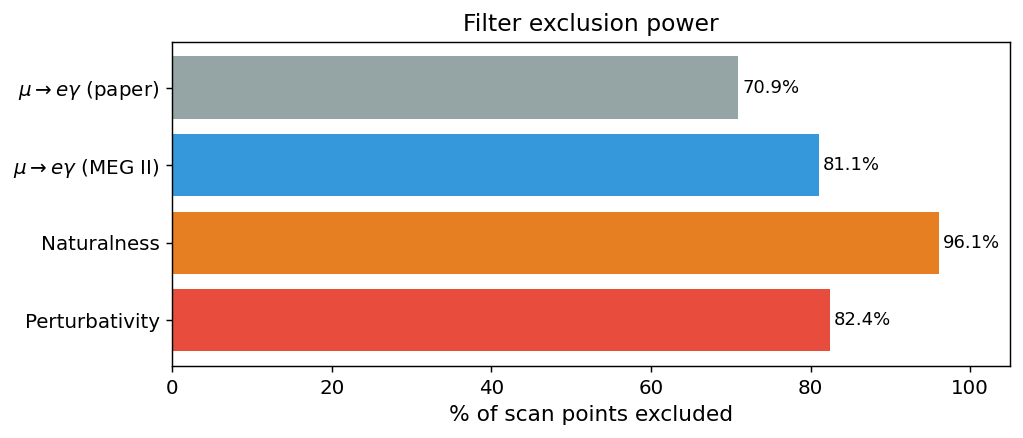

Pass all (MEG II 2025):  1,222 / 465,125
Pass all (paper era):    6,098 / 465,125
Ratio: MEG II is 5.0x more permissive in the paper era


In [3]:
# Compute paper-era LFV pass/fail from existing data.
# C_MEGII = sqrt(1.5e-13 / 4e-8) ≈ 1.936e-3
# C_paper = 0.02  (Perez-Randall / MEGA era)
# A point passes paper-era LFV iff  lfv_ratio * (C_MEGII / C_paper) <= 1
C_MEGII = np.sqrt(1.5e-13 / 4e-8)
C_PAPER = 0.02
ratio_rescale = C_MEGII / C_PAPER
df['lfv_ratio_paper'] = df['lfv_ratio'] * ratio_rescale
df['lfv_passes_paper'] = df['lfv_ratio_paper'] <= 1.0
df['passes_paper_era'] = df['perturbative'] & df['natural'] & df['lfv_passes_paper']

# Count how many points fail each filter
n = len(df)
labels = ['Perturbativity', 'Naturalness', r'$\mu\to e\gamma$ (MEG II)', r'$\mu\to e\gamma$ (paper)']
fails = [
    (~df.perturbative).sum(),
    (~df.natural).sum(),
    (~df.lfv_passes).sum(),
    (~df.lfv_passes_paper).sum(),
]

fig, ax = plt.subplots(figsize=(8, 3.5))
colors = ['#e74c3c', '#e67e22', '#3498db', '#95a5a6']
bars = ax.barh(labels, [f/n*100 for f in fails], color=colors)
ax.set_xlabel('% of scan points excluded')
ax.set_title('Filter exclusion power')
for bar, f in zip(bars, fails):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{f/n*100:.1f}%', va='center', fontsize=10)
ax.set_xlim(0, 105)
plt.tight_layout()
plt.show()

print(f'Pass all (MEG II 2025):  {df.passes_all.sum():,} / {n:,}')
print(f'Pass all (paper era):    {df.passes_paper_era.sum():,} / {n:,}')
print(f'Ratio: MEG II is {df.passes_paper_era.sum() / max(df.passes_all.sum(), 1):.1f}x more permissive in the paper era')

## 3. Parameter space slices: $c_L$ vs $c_N$

One panel per $\Lambda_{\text{IR}}$. Points colored by pass/fail under MEG II 2025 vs paper-era bound.

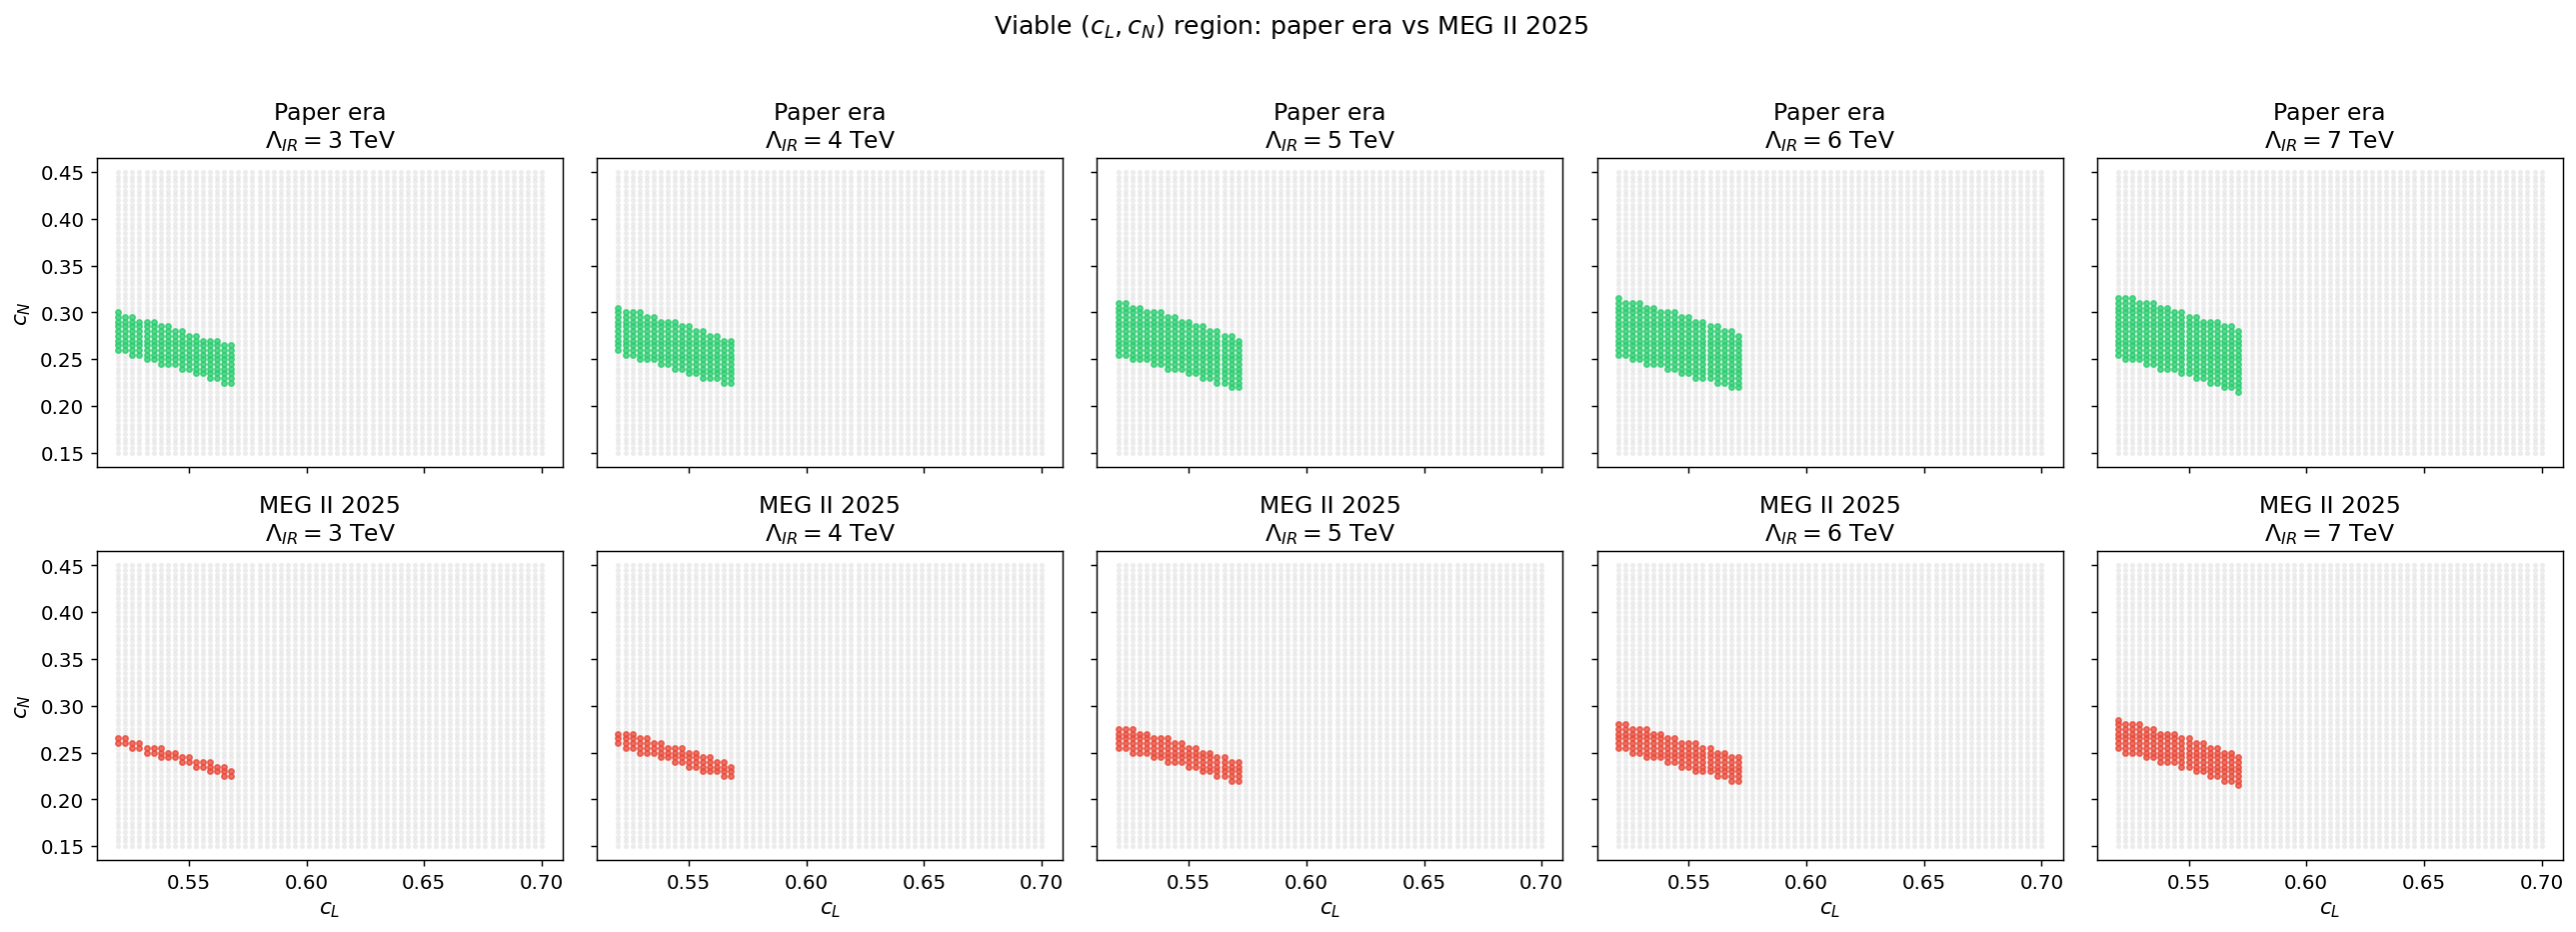

In [4]:
# For each (c_L, c_N, Lambda_IR), check if ANY lightest_nu_mass value passes.
# This gives the "best case" at each (c_L, c_N) point.
grouped = df.groupby(['c_L', 'c_N', 'Lambda_IR']).agg(
    passes_megii=('passes_all', 'any'),
    passes_paper=('passes_paper_era', 'any'),
    min_lfv_ratio=('lfv_ratio', 'min'),
    min_max_Y_bar=('max_Y_bar', 'min'),
    perturbative_any=('perturbative', 'any'),
    natural_any=('natural', 'any'),
).reset_index()

lam_vals = sorted(df.Lambda_IR.unique())

fig, axes = plt.subplots(2, len(lam_vals), figsize=(4*len(lam_vals), 7),
                          sharex=True, sharey=True)

for j, lam in enumerate(lam_vals):
    sub = grouped[grouped.Lambda_IR == lam]
    
    # Top row: paper-era
    ax = axes[0, j]
    mask_pass = sub.passes_paper
    mask_fail = ~sub.passes_paper
    ax.scatter(sub.c_L[mask_fail], sub.c_N[mask_fail], c='#dddddd', s=4, alpha=0.4, rasterized=True)
    ax.scatter(sub.c_L[mask_pass], sub.c_N[mask_pass], c='#2ecc71', s=8, alpha=0.8, rasterized=True)
    ax.set_title(f'Paper era\n$\\Lambda_{{IR}}={lam/1000:.0f}$ TeV')
    if j == 0:
        ax.set_ylabel('$c_N$')
    
    # Bottom row: MEG II 2025
    ax = axes[1, j]
    mask_pass = sub.passes_megii
    mask_fail = ~sub.passes_megii
    ax.scatter(sub.c_L[mask_fail], sub.c_N[mask_fail], c='#dddddd', s=4, alpha=0.4, rasterized=True)
    ax.scatter(sub.c_L[mask_pass], sub.c_N[mask_pass], c='#e74c3c', s=8, alpha=0.8, rasterized=True)
    ax.set_title(f'MEG II 2025\n$\\Lambda_{{IR}}={lam/1000:.0f}$ TeV')
    ax.set_xlabel('$c_L$')
    if j == 0:
        ax.set_ylabel('$c_N$')

fig.suptitle('Viable $(c_L, c_N)$ region: paper era vs MEG II 2025', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Overlay: paper-era vs MEG II viable regions

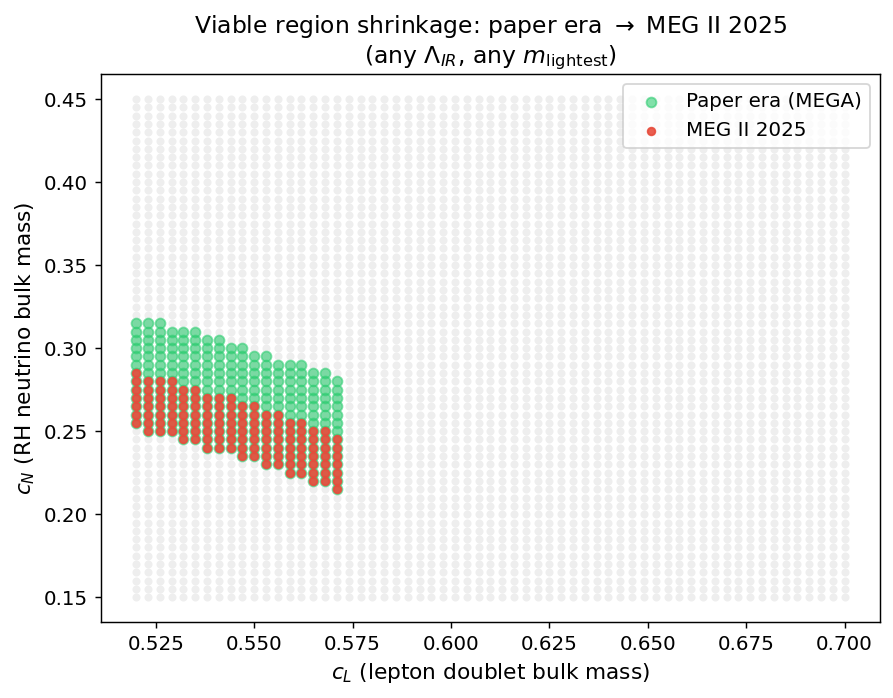

Paper era viable (c_L, c_N) points: 247
MEG II viable (c_L, c_N) points:    126
Shrinkage factor: 2.0x


In [5]:
# Aggregate over all Lambda_IR: does ANY geometry work?
agg_all = df.groupby(['c_L', 'c_N']).agg(
    passes_megii=('passes_all', 'any'),
    passes_paper=('passes_paper_era', 'any'),
    perturbative_any=('perturbative', 'any'),
    natural_any=('natural', 'any'),
).reset_index()

fig, ax = plt.subplots(figsize=(7, 5.5))

# Background: all scanned
ax.scatter(agg_all.c_L, agg_all.c_N, c='#eeeeee', s=12, zorder=1, rasterized=True)

# Paper-era viable (green, larger)
mask_p = agg_all.passes_paper
ax.scatter(agg_all.c_L[mask_p], agg_all.c_N[mask_p],
           c='#2ecc71', s=30, alpha=0.6, zorder=2, label='Paper era (MEGA)', rasterized=True)

# MEG II viable (red, on top)
mask_m = agg_all.passes_megii
ax.scatter(agg_all.c_L[mask_m], agg_all.c_N[mask_m],
           c='#e74c3c', s=18, alpha=0.9, zorder=3, label='MEG II 2025', rasterized=True)

ax.set_xlabel('$c_L$ (lepton doublet bulk mass)')
ax.set_ylabel('$c_N$ (RH neutrino bulk mass)')
ax.set_title('Viable region shrinkage: paper era $\\to$ MEG II 2025\n'
             '(any $\\Lambda_{IR}$, any $m_{\\text{lightest}}$)')
ax.legend(loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()

print(f'Paper era viable (c_L, c_N) points: {mask_p.sum()}')
print(f'MEG II viable (c_L, c_N) points:    {mask_m.sum()}')
print(f'Shrinkage factor: {mask_p.sum() / max(mask_m.sum(), 1):.1f}x')

## 5. $\bar{Y}_{\max}$ heatmap in $c_L$–$c_N$ plane

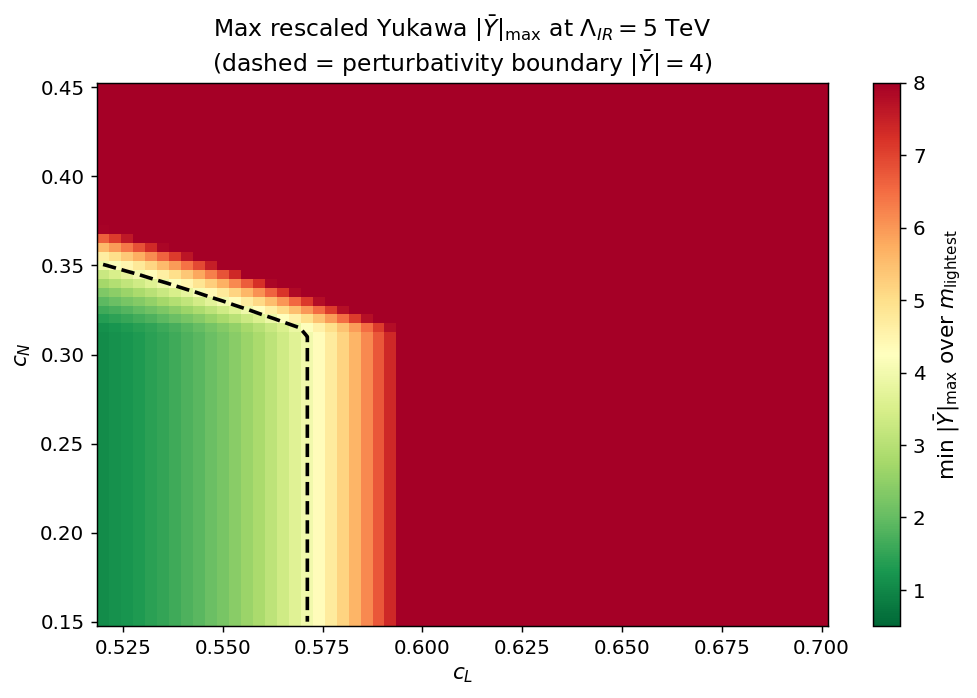

In [6]:
# Use Lambda_IR = 5000 GeV as representative
sub5 = df[df.Lambda_IR == 5000.0].copy()
heat = sub5.groupby(['c_L', 'c_N'])['max_Y_bar'].min().reset_index()

c_L_vals = np.sort(heat.c_L.unique())
c_N_vals = np.sort(heat.c_N.unique())
Z = np.full((len(c_N_vals), len(c_L_vals)), np.nan)
for _, row in heat.iterrows():
    i = np.searchsorted(c_N_vals, row.c_N)
    j = np.searchsorted(c_L_vals, row.c_L)
    Z[i, j] = row.max_Y_bar

fig, ax = plt.subplots(figsize=(8, 5.5))
pcm = ax.pcolormesh(c_L_vals, c_N_vals, Z,
                     cmap='RdYlGn_r', vmin=0.5, vmax=8,
                     shading='nearest', rasterized=True)
cbar = fig.colorbar(pcm, ax=ax, label=r'min $|\bar{Y}|_{\max}$ over $m_{\text{lightest}}$')

# Draw perturbativity contour at |Y_bar| = 4
ax.contour(c_L_vals, c_N_vals, Z, levels=[4.0], colors='black', linewidths=2, linestyles='--')
ax.set_xlabel('$c_L$')
ax.set_ylabel('$c_N$')
ax.set_title(r'Max rescaled Yukawa $|\bar{Y}|_{\max}$ at $\Lambda_{IR}=5$ TeV'
             '\n(dashed = perturbativity boundary $|\\bar{Y}|=4$)')
plt.tight_layout()
plt.show()

## 6. LFV ratio vs $\Lambda_{\text{IR}}$: how close are we to the bound?

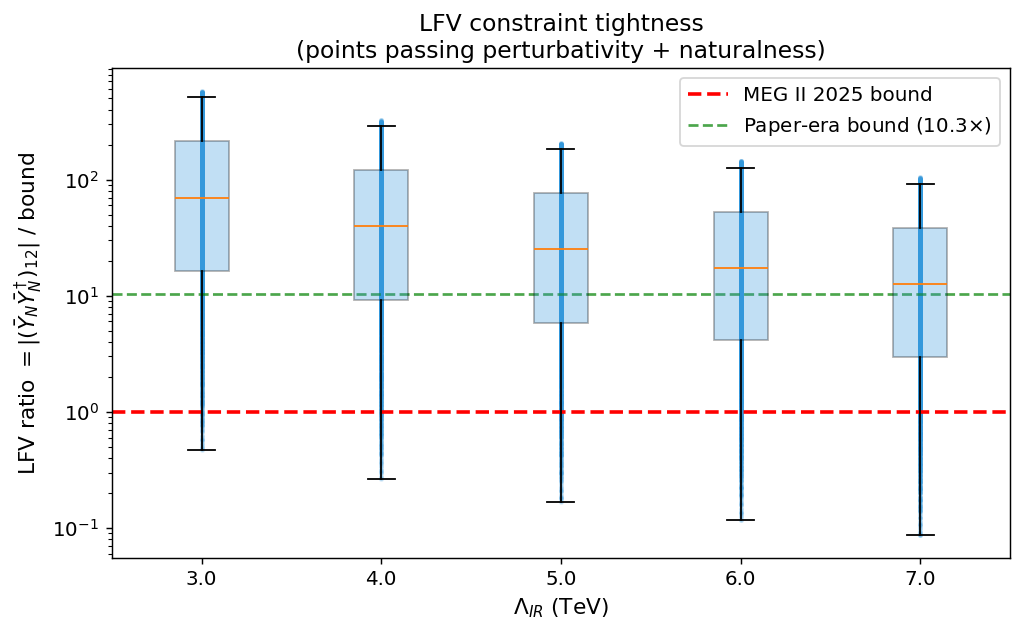

In [7]:
# For points passing perturbativity+naturalness, plot LFV ratio vs Lambda_IR
pn = df[df.perturbative & df.natural].copy()

fig, ax = plt.subplots(figsize=(8, 5))

for lam in lam_vals:
    sub = pn[pn.Lambda_IR == lam]
    ax.scatter(np.full(len(sub), lam/1000), sub.lfv_ratio,
              alpha=0.15, s=3, c='#3498db', rasterized=True)

# Box plot overlay
bp_data = [pn[pn.Lambda_IR == lam].lfv_ratio.values for lam in lam_vals]
bp = ax.boxplot(bp_data, positions=[l/1000 for l in lam_vals], widths=0.3,
                showfliers=False, patch_artist=True, zorder=5)
for patch in bp['boxes']:
    patch.set_facecolor('#3498db')
    patch.set_alpha(0.3)

ax.axhline(1.0, color='red', ls='--', lw=2, label='MEG II 2025 bound')
ax.axhline(C_PAPER / C_MEGII, color='green', ls='--', lw=1.5, alpha=0.7,
           label=f'Paper-era bound ({C_PAPER/C_MEGII:.1f}$\\times$)')

ax.set_yscale('log')
ax.set_xlabel(r'$\Lambda_{IR}$ (TeV)')
ax.set_ylabel(r'LFV ratio $= |( \bar{Y}_N \bar{Y}_N^\dagger)_{12}|$ / bound')
ax.set_title('LFV constraint tightness\n(points passing perturbativity + naturalness)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 7. Lightest neutrino mass vs $c_N$ (viable points only)

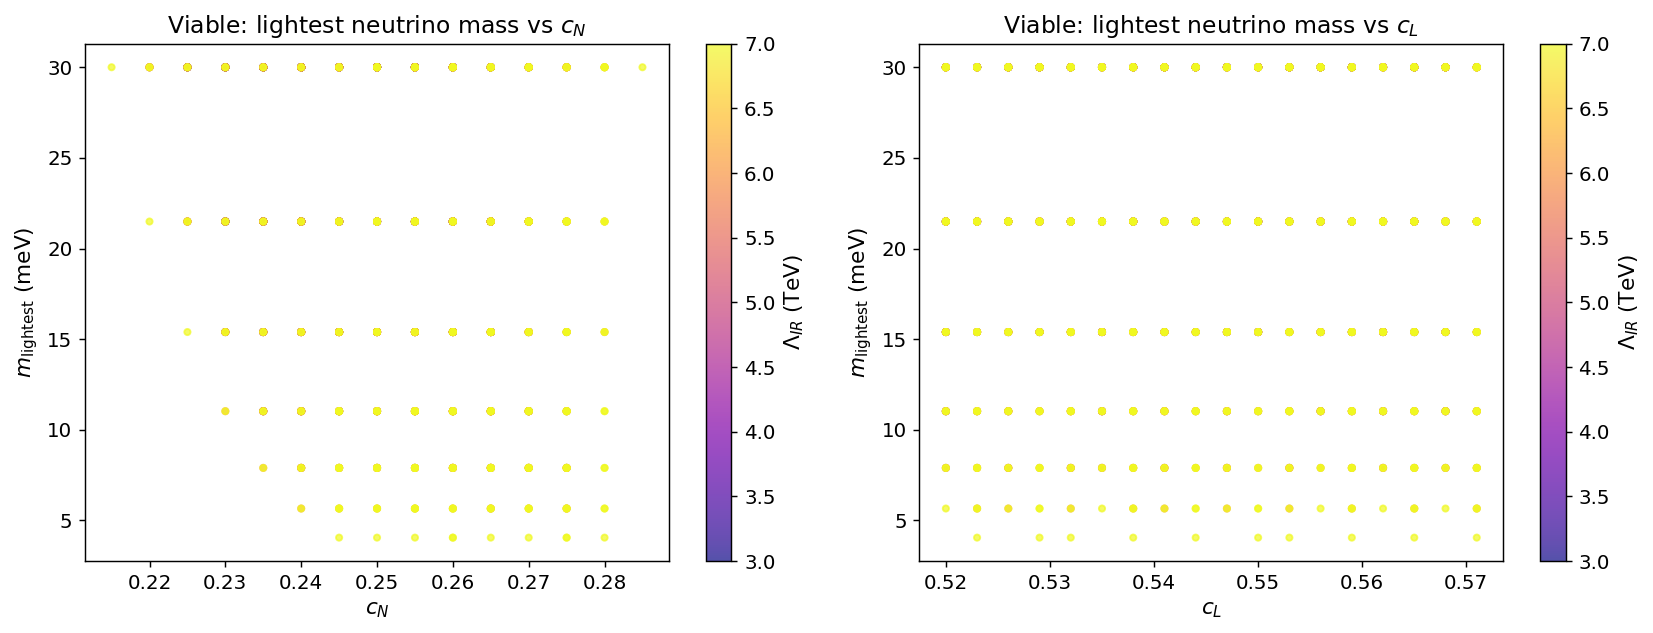

In [8]:
viable = df[df.passes_all].copy()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: m_lightest vs c_N
ax = axes[0]
sc = ax.scatter(viable.c_N, viable.lightest_nu_mass * 1e3,
                c=viable.Lambda_IR / 1000, cmap='plasma',
                s=12, alpha=0.7, rasterized=True)
fig.colorbar(sc, ax=ax, label=r'$\Lambda_{IR}$ (TeV)')
ax.set_xlabel('$c_N$')
ax.set_ylabel(r'$m_{\text{lightest}}$ (meV)')
ax.set_title('Viable: lightest neutrino mass vs $c_N$')

# Right: m_lightest vs c_L
ax = axes[1]
sc = ax.scatter(viable.c_L, viable.lightest_nu_mass * 1e3,
                c=viable.Lambda_IR / 1000, cmap='plasma',
                s=12, alpha=0.7, rasterized=True)
fig.colorbar(sc, ax=ax, label=r'$\Lambda_{IR}$ (TeV)')
ax.set_xlabel('$c_L$')
ax.set_ylabel(r'$m_{\text{lightest}}$ (meV)')
ax.set_title('Viable: lightest neutrino mass vs $c_L$')

plt.tight_layout()
plt.show()

---
# Do we need to raise $M_{KK}$?

The LFV bound scales as $M_{KK}^2$: higher KK masses suppress $\mu\to e\gamma$.  
Below we extrapolate the scan data to higher $M_{KK}$ values to see how the viable region grows.

## 8. Acceptance rate vs $\Lambda_{IR}$

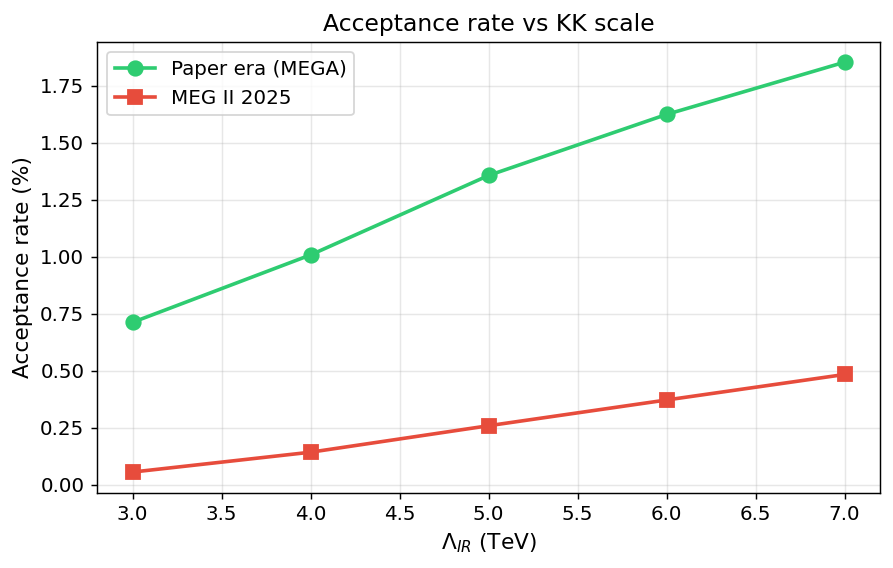

 Lambda_IR  n_megii  n_paper  rate_megii  rate_paper
    3000.0       52      663    0.055899    0.712712
    4000.0      133      938    0.142972    1.008331
    5000.0      241     1262    0.259070    1.356625
    6000.0      346     1511    0.371943    1.624295
    7000.0      450     1724    0.483741    1.853265


In [9]:
acc_by_lam = df.groupby('Lambda_IR').agg(
    n_total=('passes_all', 'count'),
    n_megii=('passes_all', 'sum'),
    n_paper=('passes_paper_era', 'sum'),
).reset_index()
acc_by_lam['rate_megii'] = 100 * acc_by_lam.n_megii / acc_by_lam.n_total
acc_by_lam['rate_paper'] = 100 * acc_by_lam.n_paper / acc_by_lam.n_total

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(acc_by_lam.Lambda_IR/1000, acc_by_lam.rate_paper,
        'o-', color='#2ecc71', lw=2, ms=8, label='Paper era (MEGA)')
ax.plot(acc_by_lam.Lambda_IR/1000, acc_by_lam.rate_megii,
        's-', color='#e74c3c', lw=2, ms=8, label='MEG II 2025')

ax.set_xlabel(r'$\Lambda_{IR}$ (TeV)')
ax.set_ylabel('Acceptance rate (%)')
ax.set_title('Acceptance rate vs KK scale')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(acc_by_lam[['Lambda_IR', 'n_megii', 'n_paper', 'rate_megii', 'rate_paper']].to_string(index=False))

## 9. Minimum $M_{KK}$ needed for each $(c_L, c_N)$ point

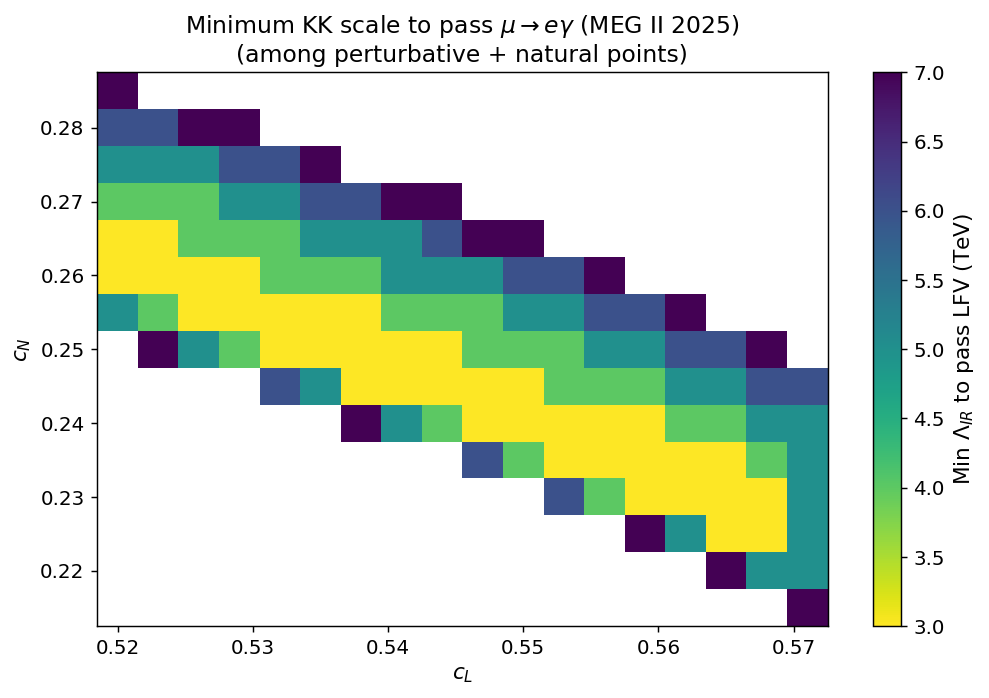

In [10]:
# For points passing perturbativity + naturalness, find the minimum
# M_KK = Lambda_IR at which LFV passes (using the best lightest_nu_mass).
pn = df[df.perturbative & df.natural].copy()

# For each (c_L, c_N), find the minimum Lambda_IR where LFV passes
viable_pn = pn[pn.lfv_passes]
if len(viable_pn) > 0:
    min_lam = viable_pn.groupby(['c_L', 'c_N'])['Lambda_IR'].min().reset_index()
    min_lam.rename(columns={'Lambda_IR': 'min_Lambda_IR'}, inplace=True)

    c_L_u = np.sort(min_lam.c_L.unique())
    c_N_u = np.sort(min_lam.c_N.unique())
    Z_min = np.full((len(c_N_u), len(c_L_u)), np.nan)
    for _, row in min_lam.iterrows():
        i = np.searchsorted(c_N_u, row.c_L)  # careful with axes
        j = np.searchsorted(c_L_u, row.c_L)
        i = np.searchsorted(c_N_u, row.c_N)
        Z_min[i, j] = row.min_Lambda_IR / 1000

    fig, ax = plt.subplots(figsize=(8, 5.5))
    pcm = ax.pcolormesh(c_L_u, c_N_u, Z_min,
                         cmap='viridis_r', shading='nearest', rasterized=True)
    cbar = fig.colorbar(pcm, ax=ax, label=r'Min $\Lambda_{IR}$ to pass LFV (TeV)')
    ax.set_xlabel('$c_L$')
    ax.set_ylabel('$c_N$')
    ax.set_title(r'Minimum KK scale to pass $\mu\to e\gamma$ (MEG II 2025)'
                 '\n(among perturbative + natural points)')
    plt.tight_layout()
    plt.show()
else:
    print('No viable points found passing perturbativity + naturalness + LFV.')

## 10. Projecting to higher $M_{KK}$: how much parameter space opens up?

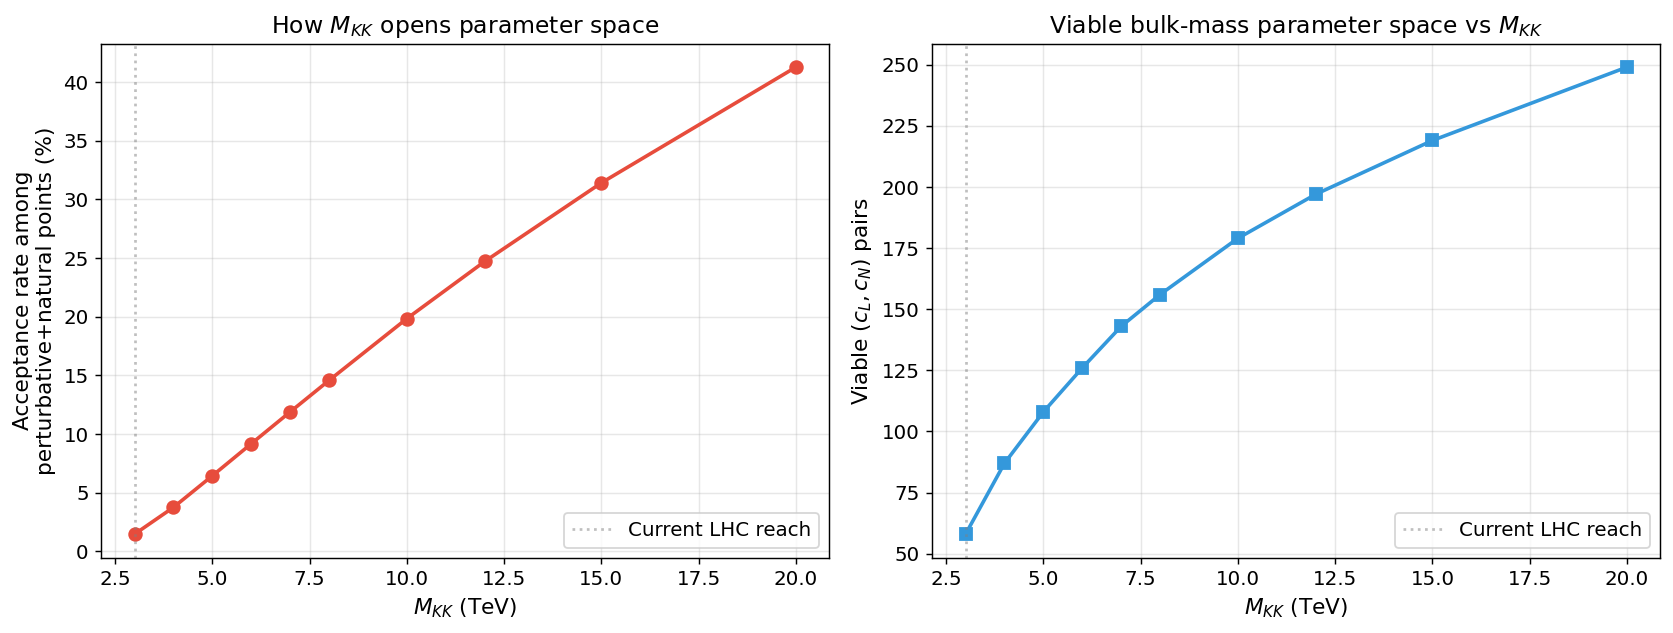

 M_KK_TeV  n_pass  rate_pct  n_cLcN
        3     269  1.471393      58
        4     687  3.757795      87
        5    1179  6.448966     108
        6    1678  9.178427     126
        7    2174 11.891478     143
        8    2665 14.577180     156
       10    3628 19.844656     179
       12    4518 24.712832     197
       15    5743 31.413412     219
       20    7546 41.275572     249


In [11]:
# The LFV bound: lhs <= C * (M_KK / 3 TeV)^2
# For a point evaluated at Lambda_IR with lfv_lhs stored, we can compute
# what M_KK is needed:  M_KK_min = 3 TeV * sqrt(lhs / C)
#
# Equivalently, at a hypothetical M_KK, the ratio becomes:
#   ratio_new = lhs / (C * (M_KK_new / 3000)^2)
#             = lfv_ratio * (Lambda_IR / M_KK_new)^2   [since xi_KK = 1]

pn = df[df.perturbative & df.natural].copy()

# Project to hypothetical M_KK values
mkk_projections = [3, 4, 5, 6, 7, 8, 10, 12, 15, 20]  # TeV

results = []
for mkk_tev in mkk_projections:
    mkk_gev = mkk_tev * 1000
    # For each point, rescale its lfv_ratio to this M_KK
    # lfv_ratio was computed at the point's own Lambda_IR.
    # ratio_new = lfv_lhs / (C * (mkk_gev / 3000)^2)
    # We stored lfv_lhs and know C = C_MEGII
    ratio_at_mkk = pn['lfv_lhs'] / (C_MEGII * (mkk_gev / 3000)**2)
    n_pass_lfv = (ratio_at_mkk <= 1.0).sum()
    n_pn = len(pn)
    
    # Unique (c_L, c_N) that pass
    pn_copy = pn.copy()
    pn_copy['_lfv_ok'] = ratio_at_mkk <= 1.0
    n_cLcN = pn_copy[pn_copy['_lfv_ok']].groupby(['c_L','c_N']).ngroups if n_pass_lfv > 0 else 0
    
    results.append({
        'M_KK_TeV': mkk_tev,
        'n_pass': n_pass_lfv,
        'rate_pct': 100 * n_pass_lfv / n_pn if n_pn > 0 else 0,
        'n_cLcN': n_cLcN,
    })

proj_df = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Left: acceptance rate vs M_KK
ax1.plot(proj_df.M_KK_TeV, proj_df.rate_pct, 'o-', color='#e74c3c', lw=2, ms=7)
ax1.axvline(3, color='gray', ls=':', alpha=0.5, label='Current LHC reach')
ax1.set_xlabel(r'$M_{KK}$ (TeV)')
ax1.set_ylabel('Acceptance rate among\nperturbative+natural points (%)')
ax1.set_title(r'How $M_{KK}$ opens parameter space')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: number of viable (c_L, c_N) pairs
ax2.plot(proj_df.M_KK_TeV, proj_df.n_cLcN, 's-', color='#3498db', lw=2, ms=7)
ax2.axvline(3, color='gray', ls=':', alpha=0.5, label='Current LHC reach')
ax2.set_xlabel(r'$M_{KK}$ (TeV)')
ax2.set_ylabel(r'Viable $(c_L, c_N)$ pairs')
ax2.set_title(r'Viable bulk-mass parameter space vs $M_{KK}$')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(proj_df.to_string(index=False))

## 11. $(c_L, c_N)$ viable region at projected $M_{KK}$ values

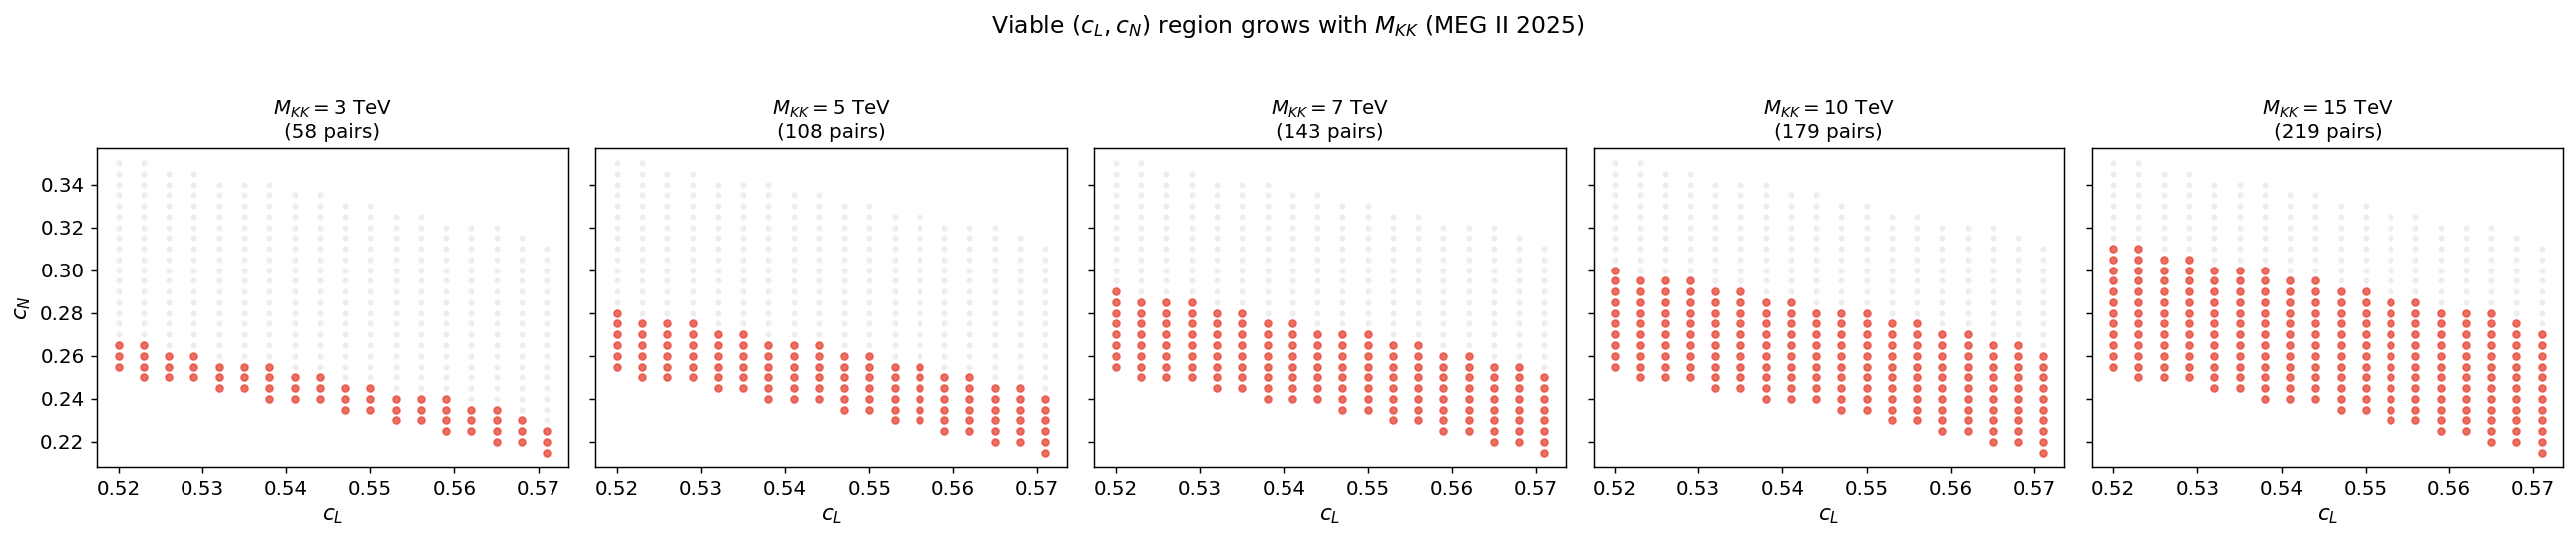

In [12]:
# Show how the viable (c_L, c_N) island grows with M_KK
pn = df[df.perturbative & df.natural].copy()

mkk_show = [3, 5, 7, 10, 15]  # TeV
fig, axes = plt.subplots(1, len(mkk_show), figsize=(4*len(mkk_show), 4),
                          sharex=True, sharey=True)

for idx, mkk_tev in enumerate(mkk_show):
    ax = axes[idx]
    mkk_gev = mkk_tev * 1000
    
    # Rescale LFV for each point to this hypothetical M_KK
    ratio_at_mkk = pn['lfv_lhs'] / (C_MEGII * (mkk_gev / 3000)**2)
    pn_here = pn.copy()
    pn_here['passes_at_mkk'] = ratio_at_mkk <= 1.0
    
    agg = pn_here.groupby(['c_L', 'c_N'])['passes_at_mkk'].any().reset_index()
    
    fail = agg[~agg.passes_at_mkk]
    ok = agg[agg.passes_at_mkk]
    
    ax.scatter(fail.c_L, fail.c_N, c='#dddddd', s=6, alpha=0.4, rasterized=True)
    ax.scatter(ok.c_L, ok.c_N, c='#e74c3c', s=14, alpha=0.8, rasterized=True)
    ax.set_title(f'$M_{{KK}} = {mkk_tev}$ TeV\n({len(ok)} pairs)', fontsize=11)
    ax.set_xlabel('$c_L$')
    if idx == 0:
        ax.set_ylabel('$c_N$')

fig.suptitle(r'Viable $(c_L, c_N)$ region grows with $M_{KK}$ (MEG II 2025)',
             fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

## 12. Minimum $M_{KK}$ to rescue each $(c_L, c_N)$ point

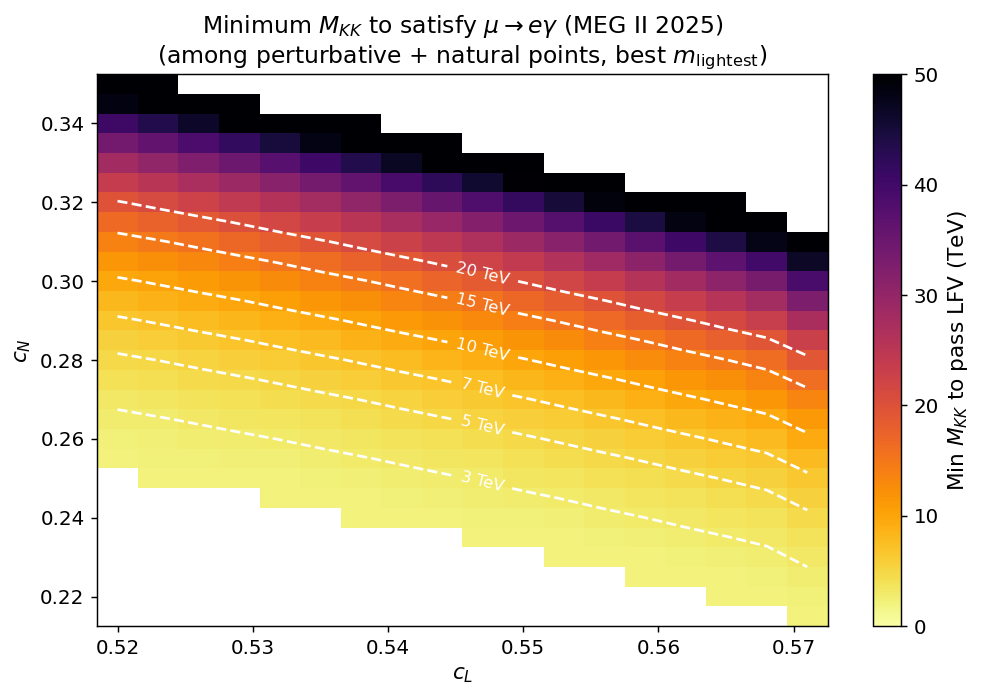

Min M_KK across all (c_L, c_N): 2.0 TeV
Median M_KK:                     10.3 TeV
Points with M_KK < 7 TeV:        143 / 363
Points with M_KK < 10 TeV:       179 / 363
Points with M_KK < 15 TeV:       219 / 363


In [13]:
# For each (c_L, c_N) that passes perturbativity + naturalness,
# find the minimum M_KK (in TeV) such that LFV passes for at least
# one value of lightest_nu_mass.
# M_KK_min = 3 TeV * sqrt(lhs_min / C)

pn = df[df.perturbative & df.natural].copy()
min_lhs = pn.groupby(['c_L', 'c_N'])['lfv_lhs'].min().reset_index()
min_lhs['mkk_min_TeV'] = 3.0 * np.sqrt(min_lhs['lfv_lhs'] / C_MEGII)

c_L_u = np.sort(min_lhs.c_L.unique())
c_N_u = np.sort(min_lhs.c_N.unique())
Z_mkk = np.full((len(c_N_u), len(c_L_u)), np.nan)
for _, row in min_lhs.iterrows():
    i = np.searchsorted(c_N_u, row.c_N)
    j = np.searchsorted(c_L_u, row.c_L)
    Z_mkk[i, j] = row.mkk_min_TeV

fig, ax = plt.subplots(figsize=(8, 5.5))
pcm = ax.pcolormesh(c_L_u, c_N_u, Z_mkk,
                     cmap='inferno_r', shading='nearest',
                     vmin=0, vmax=50, rasterized=True)
cbar = fig.colorbar(pcm, ax=ax, label=r'Min $M_{KK}$ to pass LFV (TeV)')

# Contour lines at key M_KK thresholds
contour_levels = [3, 5, 7, 10, 15, 20]
cs = ax.contour(c_L_u, c_N_u, Z_mkk, levels=contour_levels,
                colors='white', linewidths=1.5, linestyles='--')
ax.clabel(cs, fmt='%d TeV', fontsize=9, colors='white')

ax.set_xlabel('$c_L$')
ax.set_ylabel('$c_N$')
ax.set_title(r'Minimum $M_{KK}$ to satisfy $\mu\to e\gamma$ (MEG II 2025)'
             '\n(among perturbative + natural points, best $m_{\\text{lightest}}$)')
plt.tight_layout()
plt.show()

# Print summary statistics
mkk_flat = min_lhs.mkk_min_TeV
print(f'Min M_KK across all (c_L, c_N): {mkk_flat.min():.1f} TeV')
print(f'Median M_KK:                     {mkk_flat.median():.1f} TeV')
print(f'Points with M_KK < 7 TeV:        {(mkk_flat < 7).sum()} / {len(mkk_flat)}')
print(f'Points with M_KK < 10 TeV:       {(mkk_flat < 10).sum()} / {len(mkk_flat)}')
print(f'Points with M_KK < 15 TeV:       {(mkk_flat < 15).sum()} / {len(mkk_flat)}')

## 13. Summary

In [14]:
viable = df[df.passes_all]
paper_viable = df[df.passes_paper_era]

print('=' * 65)
print('SCAN RESULTS SUMMARY')
print('=' * 65)
print(f'Total points scanned:              {len(df):>10,}')
print(f'Pass all (MEG II 2025):            {len(viable):>10,}  ({100*len(viable)/len(df):.2f}%)')
print(f'Pass all (paper era):              {len(paper_viable):>10,}  ({100*len(paper_viable)/len(df):.2f}%)')
print(f'Shrinkage factor:                  {len(paper_viable)/max(len(viable),1):>10.1f}x')
print()
print('VIABLE PARAMETER RANGES (MEG II 2025):')
print(f'  c_L:              [{viable.c_L.min():.4f},  {viable.c_L.max():.4f}]')
print(f'  c_N:              [{viable.c_N.min():.4f},  {viable.c_N.max():.4f}]')
print(f'  Lambda_IR:        [{viable.Lambda_IR.min()/1000:.0f},       {viable.Lambda_IR.max()/1000:.0f}] TeV')
print(f'  m_lightest:       [{viable.lightest_nu_mass.min()*1e3:.1f},    {viable.lightest_nu_mass.max()*1e3:.1f}] meV')
print(f'  max |Y_bar|:      [{viable.max_Y_bar.min():.2f},   {viable.max_Y_bar.max():.2f}]')
print(f'  LFV ratio:        [{viable.lfv_ratio.min():.3f},   {viable.lfv_ratio.max():.3f}]')
print()
print('ACCEPTED BY Lambda_IR:')
for lam in sorted(viable.Lambda_IR.unique()):
    n = (viable.Lambda_IR == lam).sum()
    print(f'  {lam/1000:.0f} TeV:  {n:>5}')
print('=' * 65)

SCAN RESULTS SUMMARY
Total points scanned:                 465,125
Pass all (MEG II 2025):                 1,222  (0.26%)
Pass all (paper era):                   6,098  (1.31%)
Shrinkage factor:                         5.0x

VIABLE PARAMETER RANGES (MEG II 2025):
  c_L:              [0.5200,  0.5710]
  c_N:              [0.2150,  0.2850]
  Lambda_IR:        [3,       7] TeV
  m_lightest:       [4.1,    30.0] meV
  max |Y_bar|:      [1.06,   3.98]
  LFV ratio:        [0.087,   1.000]

ACCEPTED BY Lambda_IR:
  3 TeV:     52
  4 TeV:    133
  5 TeV:    241
  6 TeV:    346
  7 TeV:    450
